# SCAnalysis for single cell RNA-seq

This notebook details the usage of SCAnalysis for single cell RNA-seq data.

## Table of Contents

1. [Introduction](#intro)
2. [Loading Data](#loading)
3. [Data Preprocessing](#preprocessing)
4. [General Plots](#genplot):
    *a. [PCA visualization](#pcavisual)
    b. [tSNE visualization](#tsnevisual)
    c. [Diffusion maps visualization](#dmvisual)*   
5. [Gene Set Enrichment Analysis (GSEA)](#gsea)
6. [Running Wishbone](#wishbone)
7. [Plotting Wishbone](#wbplot)
8. [Running MAGIC](#magic)
9. [Plotting MAGIC](#mgplot)
10. [Running Palantir](#palantir)

<a id="intro"></a>
## Introduction

SCAnalysis is a package for analyzing single cell data. It includes the Wishbone, MAGIC, and Palantir packages.

<a id="loading"></a>
## Loading Data

First, import the package.

In [1]:
import scanalysis

Then, you can load the data using the load function in the loadsave file of the io folder. Here, we will be using the sample_scseq_data.csv data provided in the data folder as an example.

In [2]:
df = scanalysis.io.loadsave.load("~/scanalysis/data/sample_scseq_data.csv")

Successfully loaded ~/scanalysis/data/sample_scseq_data.csv


Also, import plotting and miscellaneous.

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

<a id="preprocessing"></a>
## Data preprocessing 

### Data filtering

2.28555730901
4.07051809702


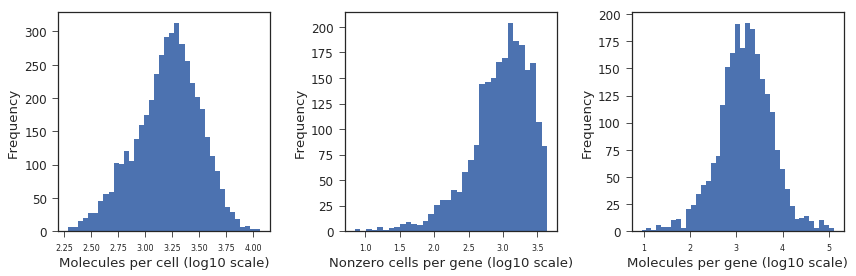

In [4]:
fig, ax = scanalysis.plots.plot.plot_molecules_per_cell_and_gene(df)

From these histograms, choose the appropriate cutoffs to filter the data. In this case, the data has already been filtered.

In [5]:
# Minimum molecules/cell value
CELL_MIN = 0

# Maximum molecules/cell values
CELL_MAX = 1000000

# Minimum number of nonzero cells/gene 
# (None if no filtering desired)
GENE_NONZERO = None

# Minimum number of molecules/gene
# (None if no filtering desired)
GENE_MOLECULES = None

In [6]:
df = scanalysis.io.preprocess.filter_scseq_data(df, filter_cell_min=CELL_MIN, filter_cell_max=CELL_MAX, 
                         filter_gene_nonzero=GENE_NONZERO, filter_gene_mols=GENE_MOLECULES)

Successfully filtered data


### Data normalization

In [7]:
data = scanalysis.io.preprocess.normalize_scseq_data(df)

Successfully normalized data


### Principal Component Analysis (PCA)

The first step in data processing for Wishbone is to determine metagenes using principal component analysis. This representation is necessary to overcome the extensive dropouts that are pervasive in single cell RNA-seq data.

For a visual representation of PCA results, see [PCA visualization](#pcavisual)

In [8]:
r1, r2 = scanalysis.utils.pca.run_pca(data)

Successfully ran PCA, and returning:
pca_projections
pca.explained_variance_ratio_


##### *Note: This sample dataset is especially sensitive, so we will be using the PCA of the original Wishbone package. (as shown below)

temp is the data after PCA is run on it.

In [9]:
import wishbone
import os

scdata = wishbone.wb.SCData.from_csv(os.path.expanduser('~/.wishbone/data/sample_scseq_data.csv'), data_type='sc-seq', normalize=True)
scdata.run_pca()

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [10]:
from copy import deepcopy
import numpy as np
import pandas as pd

n_pca_components = 5
temp = deepcopy(scdata.data)
temp -= np.min(np.ravel(temp))
temp /= np.max(np.ravel(temp))
temp = pd.DataFrame(np.dot(temp, scdata.pca['loadings'].iloc[:, 0:n_pca_components]),
                    index=scdata.data.index)

### Diffusion Maps

Diffusion maps is a non-linear dimensionality reduction technique to denoise the data and capture the major axes of variation. Diffusion maps can be determined by using the run_diffusion_map function and the diffusion components visualized on tSNE maps using plot_diffusion_components. See [Diffusion map visualization](#dmvisual)

Note: PCA must be run separately on data before diffusion maps (i.e. PCA is not included in diffusion maps function)

In [11]:
tempEigvec, tempEigval = scanalysis.utils.diffusionmap.run_diffusion_map(temp)

Running Diffusion maps with the following parameters:
Normalization: smarkov
Number of nearest neighbors k: 10
Epsilon: 1.0000
(symmetric markov) ... 
0.24 seconds
Successfully ran diffusion map, and returning EigenVectors and EigenValues


### tSNE

Note: PCA must be run separately on data before tSNE (i.e. PCA is not included in tSNE function)

For a visual representation of tSNE results, see [tSNE visualization](#tsnevisual)

In [12]:
t = scanalysis.utils.tsne.TSNE()
d = t.fit_transform(temp)

In [13]:
t1 = scanalysis.utils.tsne.TSNE()
d1 = t1.fit_transform(r1)

### Saving Data **might need to revise

Data can be saved to a pickle file and loaded using the save and load functions. 

In [14]:
scanalysis.io.loadsave.save(data, 'mouse_marrow_scdata.p')
p = scanalysis.io.loadsave.load('mouse_marrow_scdata.p')

Press enter to overwrite.
Press Ctrl-C to exit and try again with a different file name.
Successfully saved as mouse_marrow_scdata.p
Successfully loaded mouse_marrow_scdata.p


<a id="genplot"></a>
## General Plots

<a id="pcavisual"></a>
### PCA visualization

*Note: Run the plot_pca_variance_explained function WITHOUT running PCA on the data beforehand, since PCA will be run automatically.*

Results shown below for plot_pca_variance_explained_v1, which is Wishbone's version of the function.

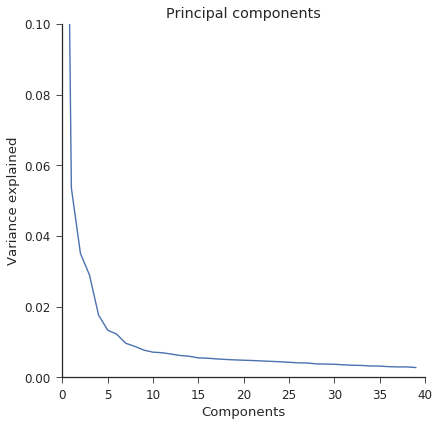

In [15]:
fig, ax = scanalysis.plots.plot.plot_pca_variance_explained_v1(data, n_components=40, random=True)

Results shown below for plot_pca_variance_explained_v2, which is MAGIC's version of the function.

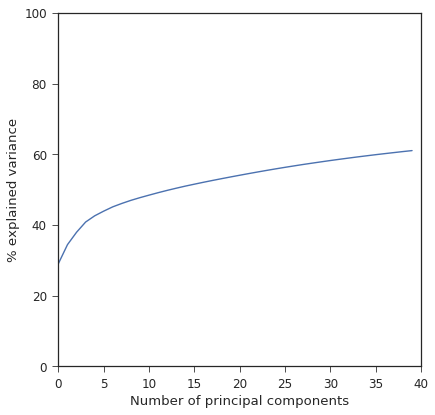

In [16]:
fig, ax = scanalysis.plots.plot.plot_pca_variance_explained_v2(data, n_components=40, random=True)

<a id="tsnevisual"></a>
### tSNE visualization

Wishbone uses tSNE for visualization and tSNE can be run using the run_tsne function which takes the number of principal components as the parameter. From the above plot, 5 seems an appropriate number of components to use.

tSNE results can be visualized by the plot_tsne and plot_tsne_by_cell_sizes functions. The plot_tsne_by_cell_sizes function colors the cells by their molecule counts before normalization.

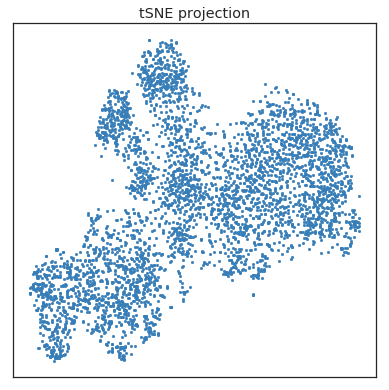

In [17]:
fig, ax = scanalysis.plots.plot.plot_tsne(d1)

(<matplotlib.figure.Figure at 0x1143b7780>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1143b77b8>)

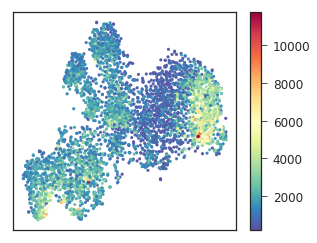

In [18]:
fig = plt.figure(figsize=[5, 4])
scanalysis.plots.plot.plot_tsne_by_cell_sizes(df,d1, fig = fig)

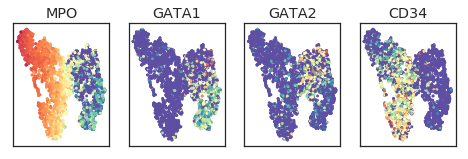

In [19]:
fig, ax = scanalysis.plots.plot.plot_gene_expression(data, d, genes = ['CD34', 'GATA2', 'GATA1', 'MPO'])

<a id="dmvisual"></a>
### Diffusion map visualization

*Note: Please run diffusion maps and tSNE before plotting diffusion components (via plot_diffusion_components function).*

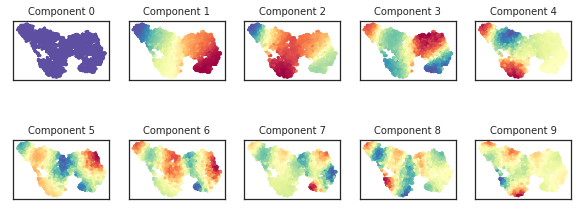

In [20]:
fig, ax = scanalysis.plots.plot.plot_diffusion_components(d, tempEigvec, tempEigval)

The run_diffusion_map_correlations function is designed to work for single cell RNA-seq (not mass-cyt).
Please run diffusion maps using run_diffusion_map before determining correlations.

Note: the component 0 is the trivial component and does not encode any information of the data.

In [21]:
dmap_corr = scanalysis.plots.plot.run_diffusion_map_correlations(data, tempEigvec)

After determining the diffusion map correlations, we can plot the gene component correlations (via plot_gene_component_correlations function).

(<matplotlib.figure.Figure at 0x114e056a0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x114b3ad68>)

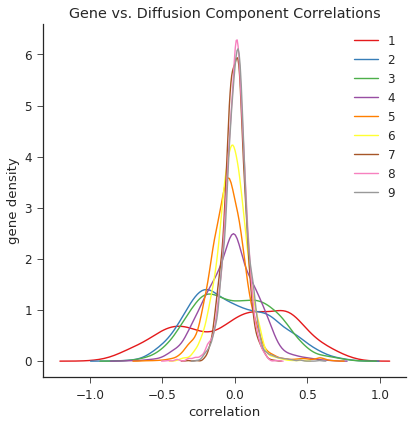

In [22]:
scanalysis.plots.plot.plot_gene_component_correlations(dmap_corr)

<a id="gsea"></a>
## Gene Set Enrichment Analysis (GSEA)

The enrichments can be determined using the run_gsea function. This function needs the prefix for generating GSEA reports and a gmt file representing the different gene sets. The following invocation of the function shows the supported set of gmt files.

*Note: Please make sure to run run_diffusion_map_correlations() before running GSEA to annotate those components.*

Note: The gmt files package with Wishbone/SCAnalysis assume all the gene names to be upper case. This can be ensured using the following code to convert them to upper case.

In [23]:
data.columns = data.columns.str.upper()

In [24]:
scanalysis.tools.wb.gsea.run_gsea(dmap_corr, output_stem= os.path.expanduser('~/.scanalysis/tools/gsea/mouse_marrow'))

Available GSEA .gmt files:

mouse:
gofat.bp.v1.0.gmt.txt
gofat.cc.v1.0.gmt.txt
gofat.mf.v1.0.gmt.txt

human:
c1.all.v5.0.symbols.gmt.txt
c2.all.v5.0.symbols.gmt.txt
c3.all.v5.0.symbols.gmt.txt
c5.all.v5.0.symbols.gmt.txt
c6.all.v5.0.symbols.gmt.txt
c7.all.v5.0.symbols.gmt.txt
gofat.bp.v1.0.gmt.txt
gofat.cc.v1.0.gmt.txt
gofat.mf.v1.0.gmt.txt
h.all.v5.0.symbols.gmt.txt

Please specify the gmt_file parameter as gmt_file=(organism, filename)


Since this is data from mouse, gmt_file parameter can be set to (mouse, gofat.bp.v1.0.gmt.txt)

In [25]:
reports = scanalysis.tools.wb.gsea.run_gsea(dmap_corr, output_stem= os.path.expanduser('~/.scanalysis/gsea/mouse_marrow'), 
                          gmt_file=('mouse', 'gofat.bp.v1.0.gmt.txt'))

If running in notebook, please look at the command line window for GSEA progress log


The detailed reports can be found at ~/.wishbone/gsea/

In [26]:
!open ~/.scanalysis/gsea/

run_gsea function also returns the top enrichment gene sets along each component. GSEA determines enrichments that are either positively or negatively correlated with the gene component correlations. In this dataset, components 1 and 2 show relevant enrichments and are used for running Wishbone/SCAnalysis. Please see Selection of diffusion components for single cell RNA-seq section of the Supplementary Methods for more details.

In [27]:
# Component 1 enrichments
reports[1]['neg']

NAME
GO_0006952|DEFENSE RESPONSE        0.000000
GO_0006955|IMMUNE RESPONSE         0.000000
GO_0009611|RESPONSE TO WOUNDING    0.012386
GO_0007610|BEHAVIOR                0.026854
GO_0001775|CELL ACTIVATION         0.054647
Name: FDR q-val, dtype: float64

In [28]:
# Component 2 enrichments
reports[2]['pos']

NAME
GO_0006955|IMMUNE RESPONSE         0.000000
GO_0001775|CELL ACTIVATION         0.009294
GO_0045321|LEUKOCYTE ACTIVATION    0.012793
Name: FDR q-val, dtype: float64

<a id="wishbone"></a>
## Running Wishbone

First, create an instance of the Wishbone class.

In [29]:
w = scanalysis.tools.wb.wishbone.Wishbone()

After initialization, Wishbone can be run by specifying the start cell and number of waypoints to be used. The start cell for this dataset was chosen based on high expression of CD34. (for each dataset, there is a corresponding start cell particular to that dataset)

*Note: Keep in mind that Wishbone requires data that has been run through normalization, PCA, and diffusion maps.*

Here, we will consider only 2 components.(?)

In [30]:
w.wishbone(tempEigvec.iloc[:,[1,2]], 'W30258', k=15, l=15, num_waypoints =250, branch=True)

Building lNN graph...
lNN computed in : 0.03 seconds
Determining waypoints if not specified...
Determining shortest path distances and perspectives....
..........................................................................................................................................................................................................................................................
Time for determining distances and perspectives: 92.94 seconds
Determining branch point and branch associations...
Running iterations...
Iteration: 2
Correlation with previous iteration:  0.9993
Iteration: 3
Correlation with previous iteration:  0.9997
Iteration: 4
Correlation with previous iteration:  0.9998
Iteration: 5
Correlation with previous iteration:  0.9999
Iteration: 6
Correlation with previous iteration:  0.9999
5 realignment iterations


<a id="wbplot"></a>
## Plotting Wishbone Results

Wishbone trajectory and branch results can be visualized on tSNE maps using the plot_wishbone_on_tsne function.

*Note: Please make sure to run Wishbone before attempting to plot Wishbone results.*

Please make sure that the tSNE data entered corresponds to the Wishbone object you've entered.
    If yes, press enter to continue.
    If not, Ctrl-C to exit and retry with correct parameters.


(<matplotlib.figure.Figure at 0x114427080>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10adc63c8>)

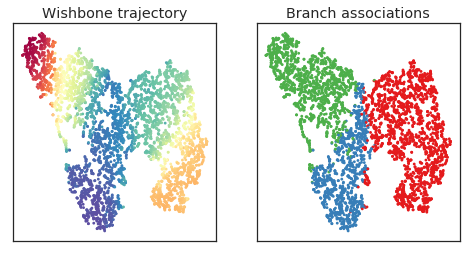

In [31]:
scanalysis.plots.wb_plot.plot_wishbone_on_tsne(w, d)

Gene expression trends along the Wishbone trajectory can be visualized using the plot_marker_trajectory function. This function also returns the smoothed trends along with the matplotlib fig, ax handler objects.

Note: Variance calculation is currently not supported for single-cell RNA-seq (sc-seq)

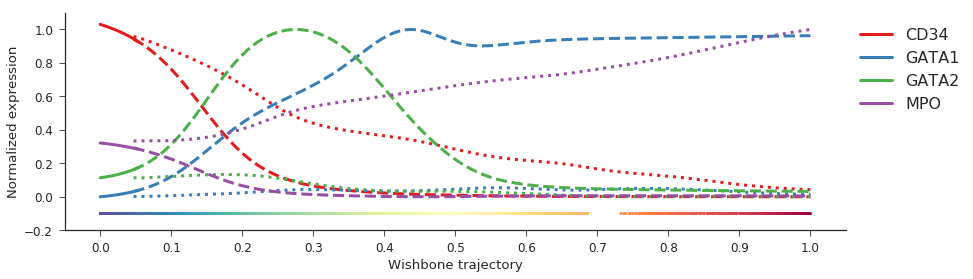

In [32]:
vals, fig, ax = scanalysis.plots.wb_plot.plot_marker_trajectory(data, w, ['CD34', 'GATA1', 'GATA2', 'MPO']);

The marker trends can be visualized as heatmaps in a given trajectory range using the following functions:

(<matplotlib.figure.Figure at 0x114a60400>,
 <matplotlib.axes._subplots.AxesSubplot at 0x118b6eda0>)

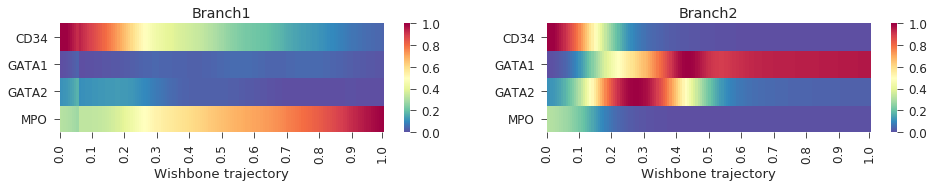

In [33]:
scanalysis.plots.wb_plot.plot_marker_heatmap(w, vals)

(<matplotlib.figure.Figure at 0x11357b518>,
 <matplotlib.axes._subplots.AxesSubplot at 0x113115748>)

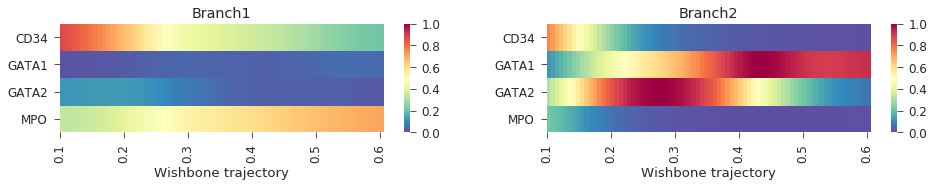

In [34]:
scanalysis.plots.wb_plot.plot_marker_heatmap(w, vals, trajectory_range=[0.1, 0.6])

The change in marker trends along the trajectory or derivatives can be visualized using these functions:

(<matplotlib.figure.Figure at 0x115856cc0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1154b9ba8>)

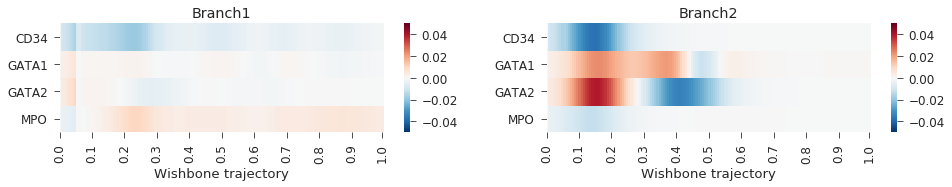

In [35]:
scanalysis.plots.wb_plot.plot_derivatives(w, vals)

(<matplotlib.figure.Figure at 0x1147760f0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1150e7f98>)

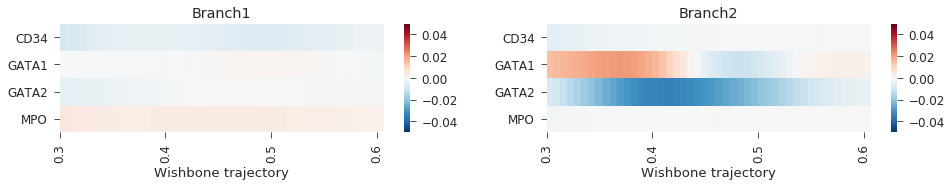

In [36]:
scanalysis.plots.wb_plot.plot_derivatives(w, vals, trajectory_range=[0.3, 0.6])

<a id="magic"></a>
## Running MAGIC

MAGIC can be run with the run_magic function.

*Note: Data should be normalized and filtered before running MAGIC. Running PCA is not necessary, since the run_magic function automatically performs PCA.*

In [37]:
new_data = scanalysis.tools.magic.run_magic(data)

Doing PCA
Successfully ran PCA, and returning:
pca_projections
pca.explained_variance_ratio_
Using pca_projections
Computing distances
Autotuning distances
Computing kernel
MAGIC: L_t = L^t
MAGIC: data_new = L_t * data


#### With original MAGIC package...

In [38]:
import magic
import os

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [39]:
scdata = magic.mg.SCData.from_csv(os.path.expanduser('~/scanalysis/data/sample_scseq_data.csv'),data_type='sc-seq', normalize=False)

In [40]:
scdata = scdata.normalize_scseq_data()

<a id="mgplot"></a>
## Plotting MAGIC Results

*Note: Please make sure to run MAGIC before attempting to plot various MAGIC results.*

### Gene-gene scatter plots

#### 2D scatter plot before MAGIC:

In [46]:
import magic

###### need to fix the color thing (can't keep calling import magic every time just to get color) 
also it doesn't work with import wishbone

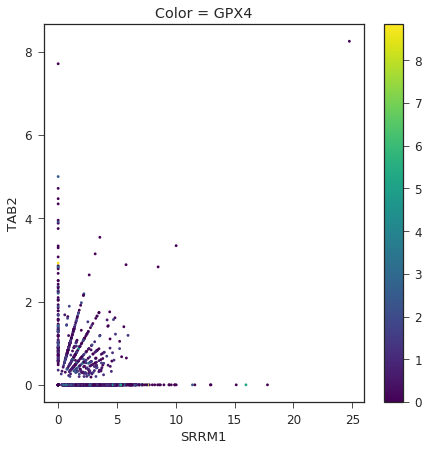

In [47]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(data, ['SRRM1', 'TAB2'], color = 'GPX4')
ax.set_xlabel('SRRM1')
ax.set_ylabel('TAB2')

You can save a figure as a png file using "savefig" as shown below.

In [48]:
scanalysis.plots.plot.savefig(fig, 'h')

In [49]:
new_data.head(5)

,MAGIC SRRM1,MAGIC ZFP106,MAGIC TAB2,MAGIC TXNRD2,MAGIC GRINL1A,MAGIC SSRP1,MAGIC EPDR1,MAGIC GPX4,MAGIC ALOX5AP,MAGIC CDK5R1,...,MAGIC ERO1L,MAGIC POC1A,MAGIC NFATC3,MAGIC ERP29,MAGIC HYOU1,MAGIC BC024571,MAGIC SCNN1A,MAGIC CBR1,MAGIC GTF2I,MAGIC AK153575
W29956,4.800304,3.511720,1.648272,0.980179,4.561081,5.066991,0.419455,2.468443,2.301637,0.149262,...,0.202991,1.255179,2.931846,4.043737,0.282273,1.649386,0.099642,2.035411,5.292813,2.037425
W30018,4.333919,3.200356,1.467656,0.808356,4.484074,5.057364,0.113394,2.203443,2.661743,0.152315,...,0.230146,1.456770,2.290270,5.207602,0.380805,1.236498,0.195205,1.394965,4.967159,1.183056
W30161,4.878276,3.675675,1.271173,1.245240,3.915136,4.073162,1.176353,3.114474,1.251764,0.096793,...,0.167862,0.825798,3.563424,2.028363,0.104745,2.176461,0.072169,3.367459,5.311819,3.204467
W30203,4.142704,2.882107,1.327618,0.818484,4.809799,4.560368,0.121396,2.395172,2.657108,0.153144,...,0.197526,1.400440,2.068123,4.976490,0.287201,1.233731,0.147210,1.500890,5.149973,1.279077
W30258,3.223066,2.190880,0.818530,0.835938,5.468429,3.128873,0.094432,2.872952,2.328955,0.202003,...,0.132449,1.650659,1.161558,5.686866,0.140059,0.964639,0.085971,1.337784,5.675283,0.943763


#### 2D scatter plot after MAGIC:

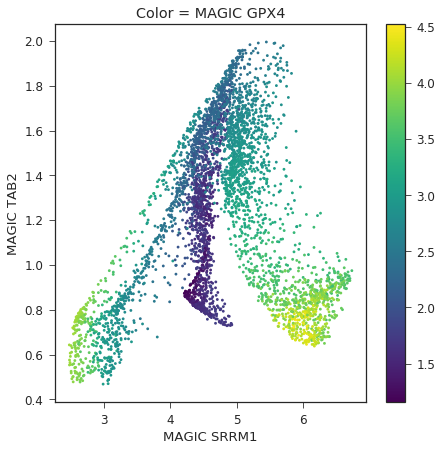

In [50]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(new_data, ['MAGIC SRRM1', 'MAGIC TAB2'], color = 'MAGIC GPX4')
ax.set_xlabel('MAGIC SRRM1')
ax.set_ylabel('MAGIC TAB2')

#### 3D scatter plot before MAGIC:

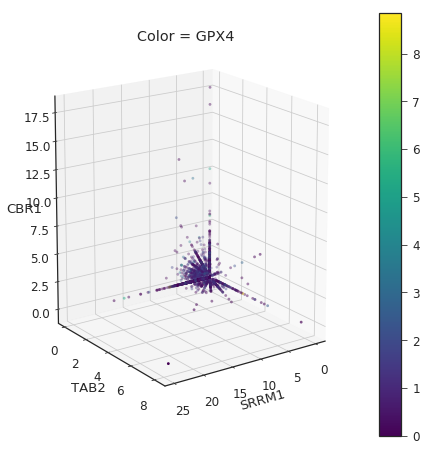

In [51]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(data, ['SRRM1', 'TAB2', 'CBR1'], color='GPX4')
ax.set_xlabel('SRRM1')
ax.set_ylabel('TAB2')
ax.set_zlabel('CBR1')

#### 3D scatter plot after MAGIC:

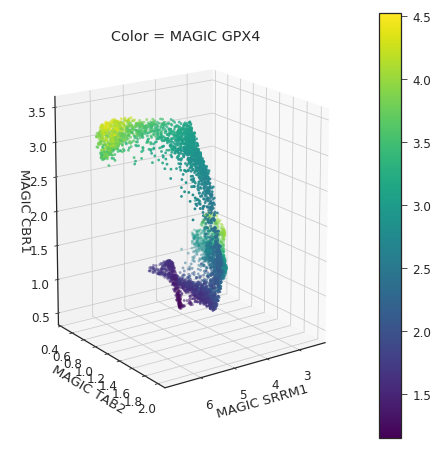

In [52]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(new_data, ['MAGIC SRRM1', 'MAGIC TAB2', 'MAGIC CBR1'], color='MAGIC GPX4')
ax.set_xlabel('MAGIC SRRM1')
ax.set_ylabel('MAGIC TAB2')
ax.set_zlabel('MAGIC CBR1')

### PCA scatter plots

#### PC2 vs PC3 colored by CDH1, VIM, FN1 and ZEB1 (before MAGIC):

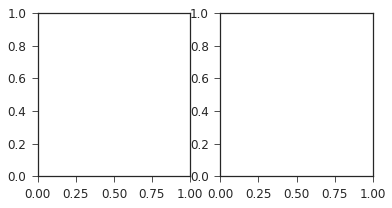

In [53]:
scanalysis.plots.plot.FigureGrid(2).savefig('h')

None of the listed genes were observed in the experiment, or the wrong symbols were used.
None of the listed genes were observed in the experiment, or the wrong symbols were used.
None of the listed genes were observed in the experiment, or the wrong symbols were used.
None of the listed genes were observed in the experiment, or the wrong symbols were used.


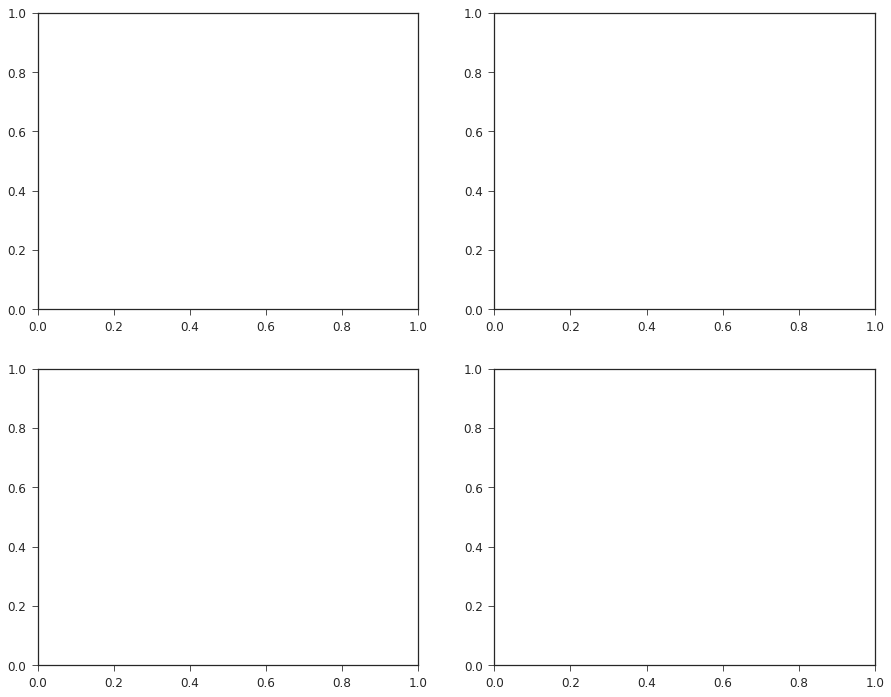

In [54]:
gs = gridspec.GridSpec(2,2)
fig = plt.figure(figsize=[15, 12])
genes = ['SRRM1', 'TAB2', 'CBR1', 'GPX4']
for i in range(len(genes)):
    ax = fig.add_subplot(gs[i//2, i%2])
    scanalysis.plots.plot.scatter_gene_expression(data, genes=['PC2', 'PC3'], color=genes[i], fig=fig, ax=ax)

#### PC2 vs PC3 colored by CDH1, VIM, FN1 and ZEB1 (after MAGIC):

### tSNE scatter plots

#### tSNE maps colored by CDH1, VIM, FN1, and ZEB1 (before MAGIC):

#### tSNE maps colored by CDH1, VIM, FN1, and ZEB1 (after MAGIC):

### original MAGIC package....

In [ ]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(scdata.data, ['SRRM1', 'TAB2'], color = 'GPX4')

In [ ]:
fig, ax = scdata.scatter_gene_expression(['SRRM1', 'TAB2'], color = 'GPX4')
ax.set_xlabel('SRRM1')
ax.set_ylabel('TAB2')

In [ ]:
scdata.run_magic()

In [ ]:
scdata.magic.scatter_gene_expression(['SRRM1', 'TAB2'], color = 'GPX4')

In [ ]:
fig, ax = scdata.scatter_gene_expression(['SRRM1', 'TAB2', 'CBR1'], color='GPX4')
ax.set_xlabel('SRRM1')
ax.set_ylabel('TAB2')
ax.set_zlabel('CBR1')

In [ ]:
fig, ax = scdata.magic.scatter_gene_expression(['SRRM1', 'TAB2', 'CBR1'], color='GPX4')
ax.set_xlabel('SRRM1')
ax.set_ylabel('TAB2')
ax.set_zlabel('CBR1')

<a id="palantir"></a>
## Running Palantir

In [ ]:
import wishbone
import os


scdata = wishbone.wb.SCData.from_csv(os.path.expanduser('~/.wishbone/data/sample_scseq_data.csv'), 
                data_type='sc-seq', normalize=True)

In [ ]:
scdata.run_pca()
scdata.run_diffusion_map()

In [ ]:
scdata.diffusion_eigenvalues.values

In [ ]:
import scanalysis

In [ ]:
DMEigVals = scanalysis.io.loadsave.load("~/palantir/dm_eig_vals.csv")

In [ ]:
DMEigVals

In [ ]:
a = scanalysis.tools.pr.p.Multibranch(DMEigVals = DMEigVals, dm_eigs = [0], start_cell="Run5_126835192163230", num_waypoints = 300, flock = 0)

In [ ]:
a.run_multibranch()

Additional parameters :
start_cell: Run5_126835192163230
num_waypoints: 300
flock = 0

In [ ]:
dm_eigs.index

In [ ]:
scdata.diffusion_eigenvalues.values[1]

In [ ]:
scdata.diffusion_eigenvectors

In [ ]:
scanalysis.tools.pr.palantir.Multibranch(scdata, dm_eigs = [1], start_cell="Run5_126835192163230", num_waypoints = 300, flock = 0)

### For reference:

In [ ]:
dm_eigs_csv = scanalysis.io.loadsave.load("~/palantir/dm_eigs.csv")
dm_eigs_csv

In [ ]:
dm_eig_vals = scanalysis.io.loadsave.load("~/palantir/dm_eig_vals.csv")
dm_eig_vals

In [ ]:
trajectory = scanalysis.io.loadsave.load("~/palantir/trajectory.csv")
trajectory

In [ ]:
tsne = scanalysis.io.loadsave.load("~/palantir/tsne.csv")
tsne